## Compare Non-Optimized Circuit and Optimized Circuit

The algorithm used in this toturial is from [QuantumFlow](https://www.nature.com/articles/s41467-020-20729-5) (Box-2 on Page 10). 

In [1]:
try:
    import torch  
    print('Module torch was installed')
except ImportError:    
    print("Installinng torch 1.8.1")
    !pip install -q torch==1.8.1
    import qiskit  

try:
    import torchvision  
    print('Module torchvision was installed')
except ImportError:    
    print("Installinng torchvision 0.4.0")
    !pip install -q torchvision==0.4.0
    import qiskit  

try:
    import qiskit  
    print('Module qiskit was installed')
except ImportError:    
    print("Installinng qiskit 0.14.0")
    !pip install -q qiskit==0.14.0
    import qiskit  


import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


import sys
import functools
from qiskit import  QuantumCircuit, ClassicalRegister
from qiskit import Aer, execute
import math

from circuit.lib_qiskit import *
import qiskit

print = functools.partial(print, flush=True)

################ Zhirui on 12-30-2020 ################
# Parameters of settings
######################################################
interest_num = [3,6]
ori_img_size = 28
img_size = 4
num_workers = 0 # number of subprocesses to use for data loading
batch_size = 1# how many samples per batch to load
inference_batch_size = 1
data_path = '/home/hzr/Software/quantum/qc_mnist/pytorch/data'
isppd = False

Module torch was installed
Module torchvision was installed
Module qiskit was installed


In [2]:
from training.lib_dataloader import to_quantum_matrix,load_data

################ Zhirui on 12-30-2020 ################
# load data.
######################################################

train_loader, test_loader = load_data(interest_num,data_path,isppd,img_size,batch_size,inference_batch_size,False)
for batch_idx, (data, target) in enumerate(test_loader):
    torch.set_printoptions(threshold=sys.maxsize)
    print("Batch Id: {}, Target: {}".format(batch_idx,target))
    quantum_matrix = to_quantum_matrix(data)
    break

Batch Id: 0, Target: tensor([0])


/home/hzr/anaconda3/envs/qf/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448216815/work/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
################ Weiwen on 12-30-2020 ################
# Parameters of the trained model
# The training procedure will be found in another repo
# https://github.com/weiwenjiang/QuantumFlow
######################################################

# Model initialization

resume_path = '/home/hzr/Software/quantum/qc_mnist/model/exe_mnist.py_2021_08_09-00_00_30/model_best.tar'
checkpoint = torch.load(resume_path, map_location='cpu')
# print(checkpoint['state_dict']['fc0.weight'])
# print(checkpoint['state_dict']['fc2.theta'])
weight = checkpoint['state_dict']['fc0.weight']
theta = checkpoint['state_dict']['fc2.theta']
print(checkpoint['state_dict'])




OrderedDict([('fc0.weight', tensor([[ 1.7893e+01,  1.3305e+01,  4.3118e+00,  7.3734e-01,  6.9442e+00,
          1.3026e+00,  1.4608e+01,  1.6279e-01,  9.4277e-01, -1.1946e+01,
         -8.5589e-02, -6.8263e+00,  1.9323e+01,  1.5560e+01,  1.4210e+01,
          1.3467e+01],
        [ 1.9825e+01,  1.5117e+01,  5.0119e+00,  1.0834e+00,  7.9358e+00,
          2.3794e+00,  1.6764e+01,  3.1214e-01,  1.2793e+00, -1.4148e+01,
         -1.3120e-01, -8.0968e+00,  2.1175e+01,  1.7749e+01,  1.5807e+01,
          1.5176e+01],
        [-1.0095e+01,  1.6023e-02,  6.3297e+00,  4.9415e+00,  2.7192e+00,
          8.2952e+00, -3.0136e+00,  5.9706e+00,  4.6358e+00,  1.4862e+01,
          9.3565e+00,  1.1284e+01, -1.3000e+01, -4.1010e+00, -1.4637e+00,
         -3.0852e+00],
        [-1.0757e+01,  8.7143e-03,  5.9497e+00,  3.4110e+00,  3.4423e+00,
          8.2286e+00, -4.7429e+00,  7.0207e+00,  5.5933e+00,  1.4061e+01,
          9.6639e+00,  1.1910e+01, -1.4176e+01, -5.9551e+00, -2.1477e+00,
         -3.998

### Non-optimized Circuit

The same with Tutorial 3

### Optimized Circuit

In the following, the optimized circuit (opt_circ) is created

Hidden layer created!


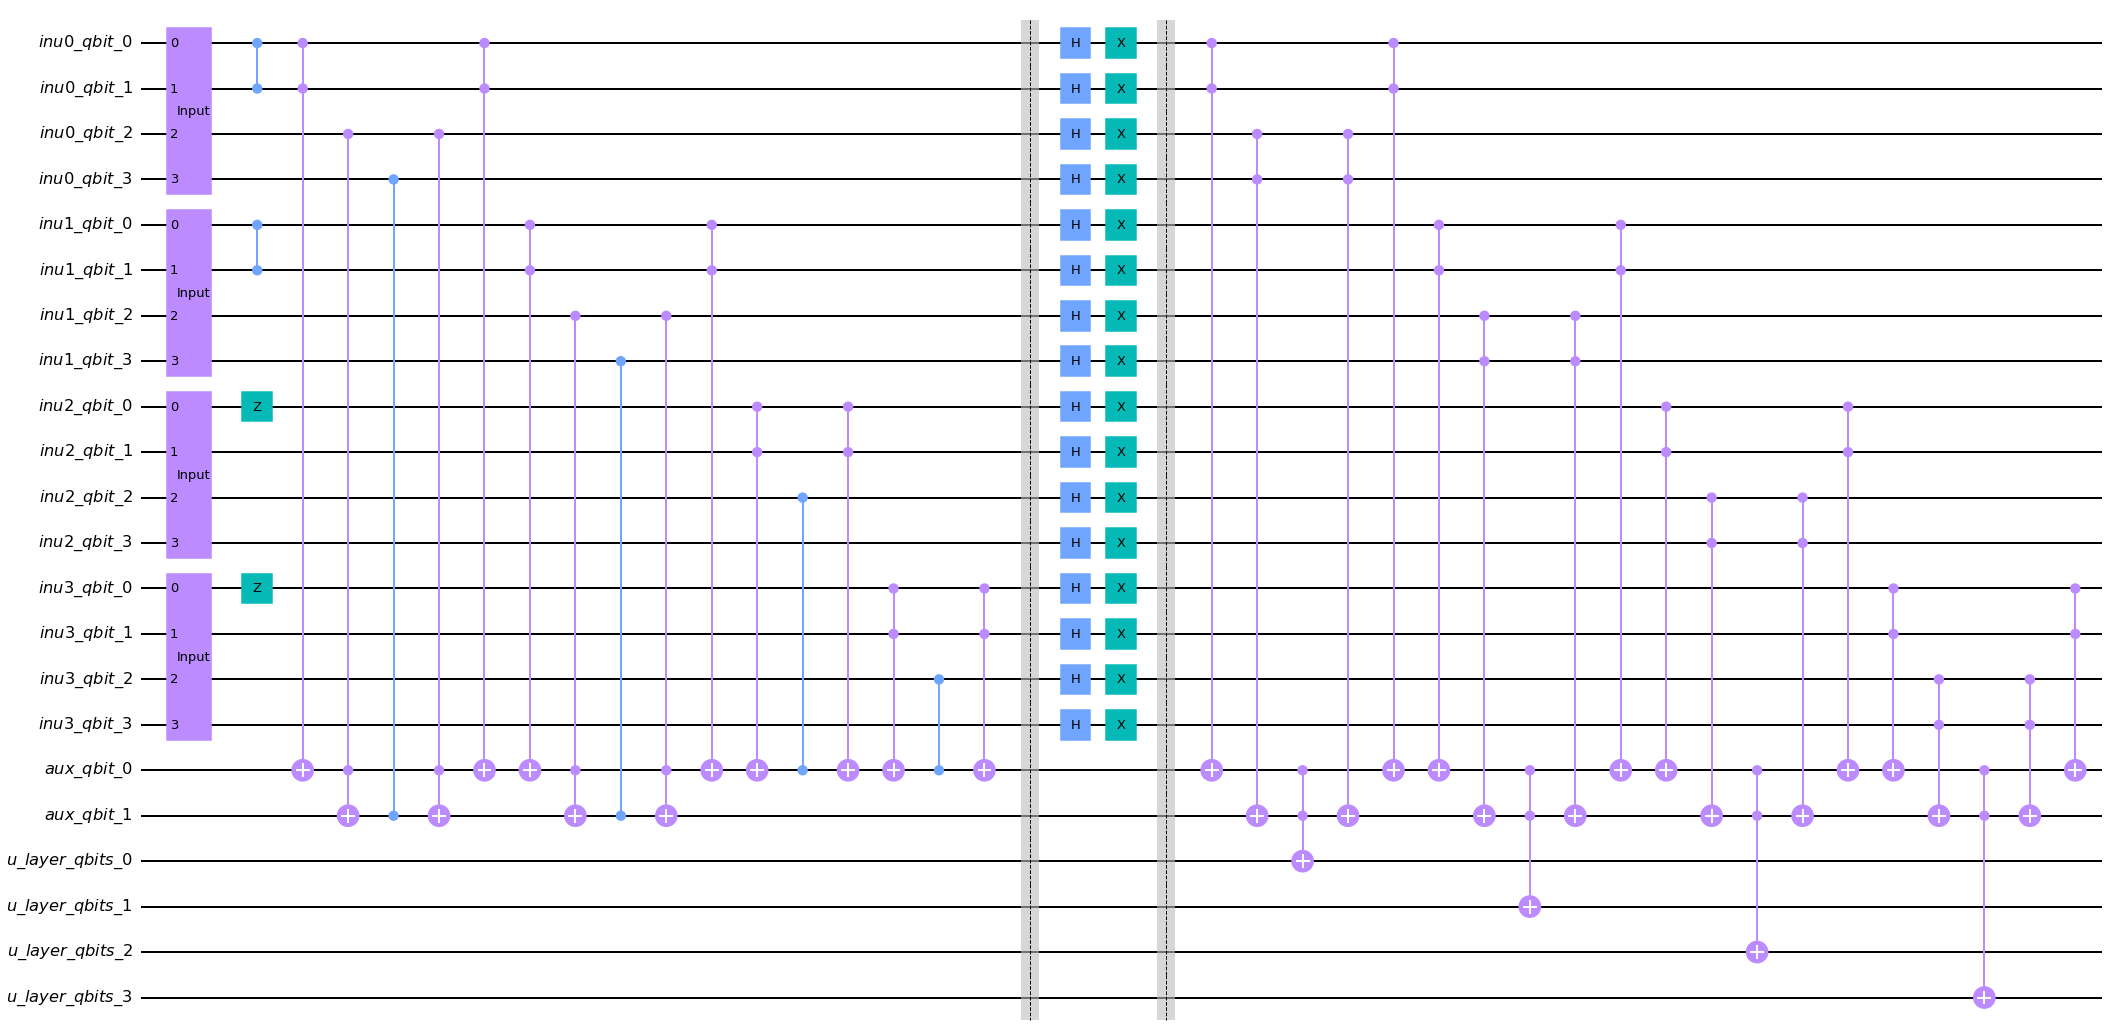

In [4]:
################ Weiwen on 12-30-2020 ################
# Generate the circuit of u-layer
######################################################
from training.lib_qf import binarize
#define your input and output number
u_layer = ULayerCircuit(16,4) 
#init circuit
circuit = QuantumCircuit()
#add input qubit to your circuit
inps = u_layer.add_in_qubits(circuit)

#add auxiliary qubit to your circuit
aux =u_layer.add_aux(circuit)

#add output qubit to your circuit
u_layer_out_qubits = u_layer.add_out_qubits(circuit)

#add ulayer to your circuit
u_layer.forward(circuit,binarize(weight),inps,u_layer_out_qubits,quantum_matrix,aux)

print("Hidden layer created!")

#show your circuit
circuit.draw('mpl',fold=50)



### Non-Optimized Circuit v.s. Optimized Circuit

Let's test and compare!


In [5]:
################ Weiwen on 12-30-2020 ################
# Quantum simulation
######################################################

# Optimized one
circuit.barrier()
c_reg = ClassicalRegister(4,"reg")
circuit.add_register(c_reg)
circuit.measure(u_layer_out_qubits[0],c_reg[0])
circuit.measure(u_layer_out_qubits[1],c_reg[1])
circuit.measure(u_layer_out_qubits[2],c_reg[2])
circuit.measure(u_layer_out_qubits[3],c_reg[3])
qc_shots=8192
opt_counts = fire_ibmq(circuit,qc_shots,True)

(opt_mycount,bits) = analyze(opt_counts)

circuit2 = QuantumCircuit()
vqc = VQuantumCircuit(4,1)
v_inps = vqc.add_input_qubits(circuit2)

opt_class_prob=[]
for b in range(bits):
    prob =float(opt_mycount[b])/qc_shots
    opt_class_prob.append(prob)
    initial_state = [prob,1-prob]
    initial_state = torch.tensor(initial_state,dtype=torch.cdouble)
    initial_state = torch.sqrt(initial_state)
    circuit2.initialize(np.array(initial_state) , b)

vqc.forward(circuit2,v_inps,'v10',np.array(theta))   

circuit2.barrier()
print(v_inps)
c_reg2 = ClassicalRegister(4,"reg2")
circuit2.add_register(c_reg2)
circuit2.measure(v_inps[0][0],c_reg2[0])
circuit2.measure(v_inps[0][1],c_reg2[1])

opt_counts = fire_ibmq(circuit2,qc_shots,True)

(opt_mycount,bits) = analyze(opt_counts)
opt_class_prob=[]
for b in range(2):
    opt_class_prob.append(float(opt_mycount[b])/qc_shots)

print("Result of u+v:",opt_class_prob)
print("Prediction class: {}".format(opt_class_prob.index(max(opt_class_prob))))
print("Target class: {}".format(target[0]))
if opt_class_prob.index(max(opt_class_prob))==target[0]:
    print("Correct prediction")
else:
    print("Incorrect prediction")
print("="*30)
circuit2.draw('mpl')

[QuantumRegister(4, 'inv0_qbit')]


CircuitError: 'cargs not in this circuit'